# Probabilistic Programming

### Preliminaries

- Goal 
  - Learn to write basic probabilistic programs
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Intro to programming in Julia (https://youtu.be/8h8rQyEpiZA?t=233).
    - Getting started with ForneyLab (https://biaslab.github.io/forneylab/docs/getting-started/).
    - Tutorials using Turing.jl (https://turing.ml/dev/tutorials/0-introduction/)

You've been deriving results by hand, but now we are to going to automate some of the labour. In this module, we will introduce you to writing probabilistic programs. We will show how to specify models and inference procedures using probabilistic programming toolboxes. Firstly, we will go throught the problem set you've seen in a previous lecture; clustering with Gaussian mixture models. Secondly, we will give you two problem sets to complete in class where you will see the strengths and weaknesses of the two major approaches to probabilistic programming. Thirdly, we will give you a series of problem sets to complete in your own time which we will discuss with you in class. 

### Problem set

Let's have another look at the Old Faithful data set. 

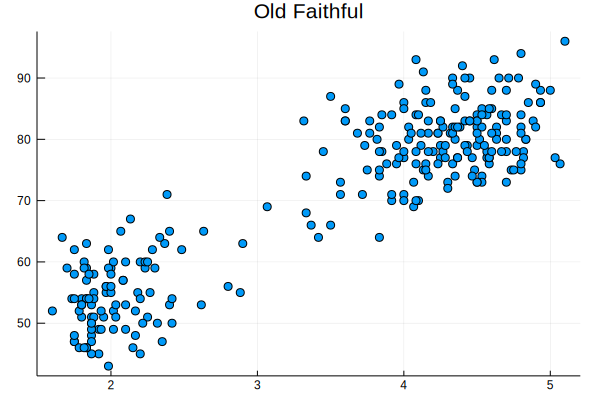

In [64]:
using DataFrames
using CSV
using StatsPlots: scatter, scatter!, contour!
using LinearAlgebra
include("scripts/gmm_plot.jl") # Holds plotting function 

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]])

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

### Inference through Monte Carlo sampling

In [53]:
using Turing, MCMCChains
Turing.setadbackend(:forward_diff); # ignore this for now

First of all, we should specify the model that we believe generated the data. 

In [72]:
@model GaussianMixtureModel(X) = begin
    
    # Shape of the data
    N, D = size(X)

    """Specify parameters"""
    
    # Specify that the center of the first cluster should be drawn from a Normal distribution
    μ1 ~ Normal()
    
    # Specify that the center of the second cluster should be drawn from a Normal distribution
    μ2 ~ Normal()
    
    # Collect cluster center parameters into a vector
    μ = [μ1, μ2]
    
    # Specify the parameter that defines what proportion of the data falls in each cluster
    w ~ Dirichlet(2, 1.0)
    
    """Draw assignments for each datum and generate it from a multivariate normal."""
    
    # Initialize vector of cluster assignments
    k = Vector{Int}(undef, N)
    
    # Loop over N samples
    for i in 1:N
        
        # For a single sample, draw probability of belonging in each cluster (a.k.a. responsibility)
        k[i] ~ Categorical(w)
        
        # Index cluster means with responsibilities
        μ_i = [μ[k[i]], μ[k[i]]]       
        
        # For each sample, draw the probability under the each cluster Normal distribution
        X[i,:] ~ MvNormal(μ_i, 1.)
        
    end
    
    return k, X
end

# Call an instance of the model
gmm_model = GaussianMixtureModel(X);

In [73]:
gmm_sampler = Gibbs(50, PG(100, 1, :k), HMC(1, 0.05, 10, :μ1, :μ2, :w))
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler), chainscat, 1);

[Gibbs] Sampling...100% Time: 0:28:38
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 1718.2743205749998;
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


As you may start to realize, sampling is slow.

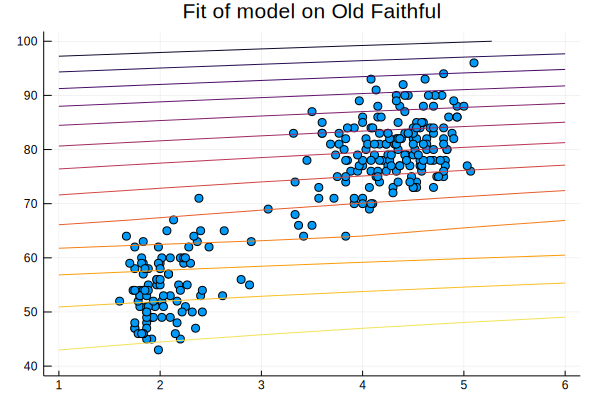

In [74]:
# Helper function used for visualizing the density region.
function predict(x, y, w, μ)
    
    # Size of grid
    N = size(x, 1)
    M = size(y, 1)
    
    probs = zeros(N, M)
    for i = 1:N
        for j = 1:M
    
            # Probabilities under each component
            prob1 = log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x[i], y[j]])
            prob2 = log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x[i], y[j]])
            
            # Add probabilities using numerical stability trick
            probs[i, j] = Turing.logaddexp(prob1, prob2)
        end
    end
    return probs
end

# Means of distributions
posterior_means = [mean(tchain[:μ1].value), mean(tchain[:μ2].value)]
posterior_props = mean(tchain[:w].value, dims=1).data[:,:,1]

# Plot iso-probability lines
xrange = range(1, stop = 6)
yrange = range(40, stop = 100)
predictions = predict(xrange, yrange, posterior_props, posterior_means)'

# Scatter points
scatter(X[:, 1], X[:,2], legend=false, title="Fit of model on Old Faithful")
contour!(xrange, yrange, predictions)

### Inference through variational approximation